Софья Ляхова

User ID: 363848868

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>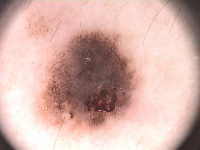</td><td>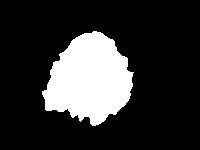</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [3]:
!wget -c https://www.dropbox.com/s/1cii0sgkcgu534k/PH2Dataset.rar

--2022-12-04 09:25:30--  https://www.dropbox.com/s/1cii0sgkcgu534k/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/1cii0sgkcgu534k/PH2Dataset.rar [following]
--2022-12-04 09:25:31--  https://www.dropbox.com/s/raw/1cii0sgkcgu534k/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfff4fa185919149574d41f024c.dl.dropboxusercontent.com/cd/0/inline/Bx9cLKhRYxE8PUekYnvo68ZrZ2ctJlNe_XY37rs3kHT77rwCoH9M2HGi3C3AEJuVsQi1FmJbg5jGbE_PGmUKeFa1LRYfigKs72LQ7JD3EzhMg8QkPi96FoJureuwo7LbuTzwpDID8r8tM98avDfSAHepE-P_zWGV-WRVwhFyeNDxig/file# [following]
--2022-12-04 09:25:31--  https://ucfff4fa185919149574d41f024c.dl.dropboxusercontent.com/cd/0/inline/Bx9cLKhRYxE8PUekYnvo68ZrZ2ctJlNe_XY37rs3kHT77rwCoH9M2HGi3C3AEJuVsQi1FmJbg5

In [4]:
!ls

PH2Dataset.rar	sample_data


In [5]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [6]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [7]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [8]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [9]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

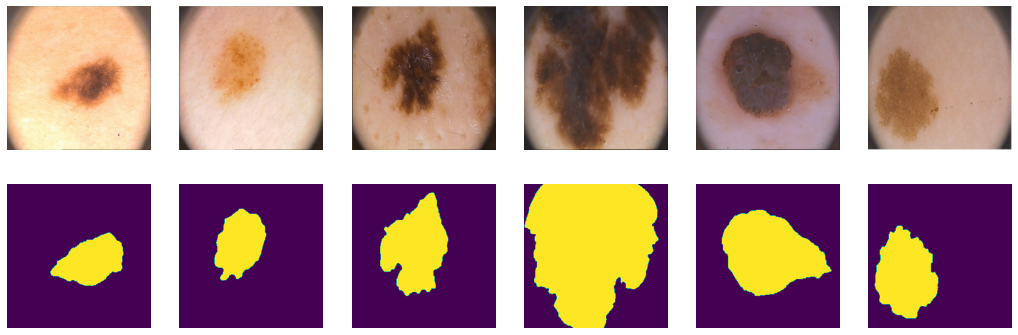

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [11]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [12]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [13]:
from torch.utils.data import DataLoader
# было изменено на 10
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

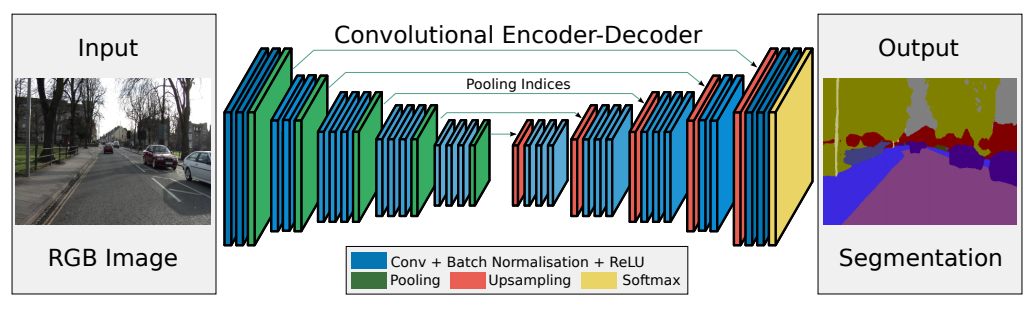

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from torch.nn.modules.pooling import MaxUnpool2d
from torch.nn.modules.batchnorm import BatchNorm2d

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [16]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 =  nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.enc_conv1 = nn.Sequential(

            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.enc_conv2 = nn.Sequential(

            nn.Conv2d(128,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.enc_conv3 = nn.Sequential(

            nn.Conv2d(256,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.enc_conv4 = nn.Sequential(

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2,return_indices=True)
        
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv0 = nn.Sequential(

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv1 = nn.Sequential(

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv2 = nn.Sequential(

            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )   
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv3 = nn.Sequential(

            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 
        self.upsample4 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv4 = nn.Sequential(

            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,1,3,padding=1),
            nn.BatchNorm2d(1),
        )
    def forward(self, x):
        # encoder
        x = self.enc_conv0(x)
        x, ind0 = self.pool0(x)
        size0 = x.size()
        
        x = self.enc_conv1(x)
        x, ind1 = self.pool1(x)
        size1 = x.size()
        
        x = self.enc_conv2(x)
        x, ind2 = self.pool2(x)
        size2 = x.size()
        
        x = self.enc_conv3(x)
        x, ind3 = self.pool3(x)
        size3 = x.size()
        
        x = self.enc_conv4(x)
        x, ind4 = self.pool4(x)
       
        # decoder
        x =  self.upsample0(x,ind4,output_size=size3)
        x = self.dec_conv0(x)

        x =  self.upsample1(x,ind3,output_size=size2)
        x = self.dec_conv1(x)

        x =  self.upsample2(x,ind2,output_size=size1)
        x = self.dec_conv2(x)

        x =  self.upsample3(x,ind1,output_size=size0)
        x = self.dec_conv3(x)

        x =  self.upsample4(x,ind0)
        x = self.dec_conv4(x)
        return x

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [93]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [18]:
def bce_loss(y_real, y_pred):
    y_real,y_pred = y_real.cpu(),y_pred.cpu()
    y_pred= (torch.sigmoid(y_pred)).float()
    loss= y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred))
    
    
    return torch.mean(loss)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [19]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    loss_tr = []
    loss_val = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_train_loss = 0
        avg_val_loss = 0

        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.cuda(), Y_batch.cuda()
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            avg_train_loss += loss.item() / len(data_tr)
        print('loss: %f' % avg_train_loss)
        loss_tr.append(avg_train_loss)

        model.eval()
        for X_val, Y_val in data_val:
            X_val = X_val.cuda()
            Y_pred = model(X_val).detach().cpu()
            loss = loss_fn(Y_val, Y_pred)
            Y_pred = torch.squeeze(Y_pred)
            Y_pred = (torch.sigmoid(Y_pred) > 0.5).type(torch.float)
            avg_val_loss += loss.item() / len(data_val)

            clear_output(wait = True)
            for k in range(5):
                plt.subplot(3, 5, k + 1)
                plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3))
                plt.title('Real')
                plt.axis('off')

                plt.subplot(3, 5, k + 6)
                plt.imshow(Y_val[k, 0], cmap = 'gray')
                plt.title('Label')
                plt.axis('off')

                plt.subplot(3, 5, k + 11)
                plt.imshow(Y_pred[k], cmap = 'gray')
                plt.title('Output')
                plt.axis('off')
            
            plt.suptitle('%d / %d - loss: %f' % (epoch + 1, epochs, avg_val_loss))
            plt.show()
        loss_val.append(avg_val_loss)
    return (loss_tr, loss_val)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [20]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [21]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric((torch.sigmoid(Y_pred)>0.5), Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [22]:
torch.cuda.memory.empty_cache()

In [24]:
def learn(model, loss, epochs, data_tr, data_val):
    optimizer = optim.AdamW(model.parameters(), lr = 1e-4)
    return train(model, optimizer, loss, epochs, data_tr, data_val)

In [25]:
from torch import optim

In [26]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Dec  4 09:28:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W /  70W |    734MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

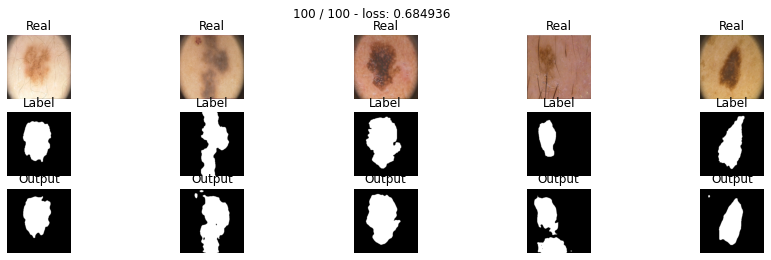

In [30]:
max_epochs = 100
segnet_model_bce = SegNet().to(device)
segnet_bce_tr, segnet_bce_val = learn(segnet_model_bce, bce_loss, max_epochs, data_tr, data_val)

In [31]:
segnet_bce_val_score = score_model(segnet_model_bce, iou_pytorch, data_val)
segnet_bce_val_score

0.7480000138282776

<Figure size 1080x288 with 0 Axes>

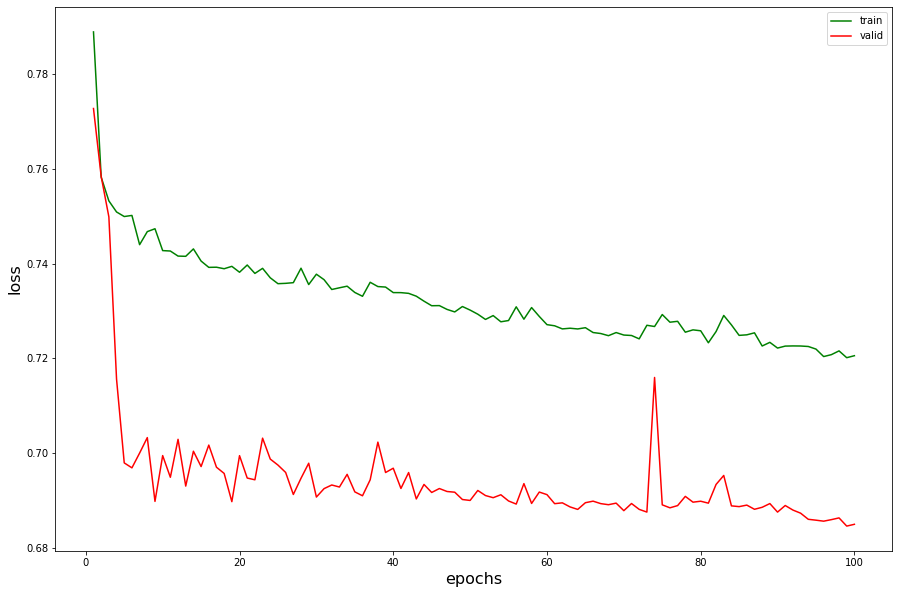

In [32]:
epochs = range(1, len(segnet_bce_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, segnet_bce_tr, label = 'train', color = 'green')
plt.plot(epochs, segnet_bce_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [38]:
def dice_loss(y_real, y_pred):
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    smooth= 1e-8
    return 1 - (1/(256*256)) * ((2. * (y_pred * y_real).sum() + smooth) / (y_real.sum() + y_pred.sum() + smooth))

Проводим тестирование:

In [39]:
torch.cuda.memory.empty_cache()

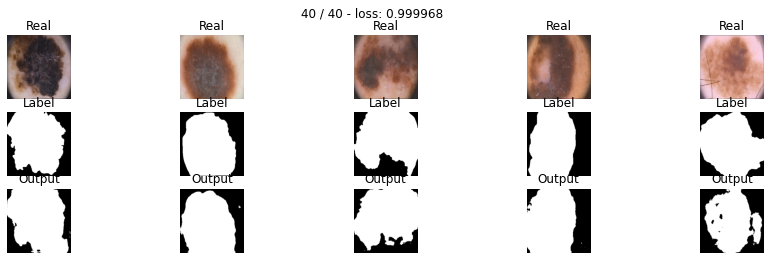

In [40]:
model_dice = SegNet().to(device)

segnet_dice_tr, segnet_dice_val = learn(model_dice, dice_loss, 40, data_tr, data_val)

In [41]:
segnet_dice_val_score = score_model(model_dice, iou_pytorch, data_val)
segnet_dice_val_score

0.7240000128746032

<Figure size 1080x288 with 0 Axes>

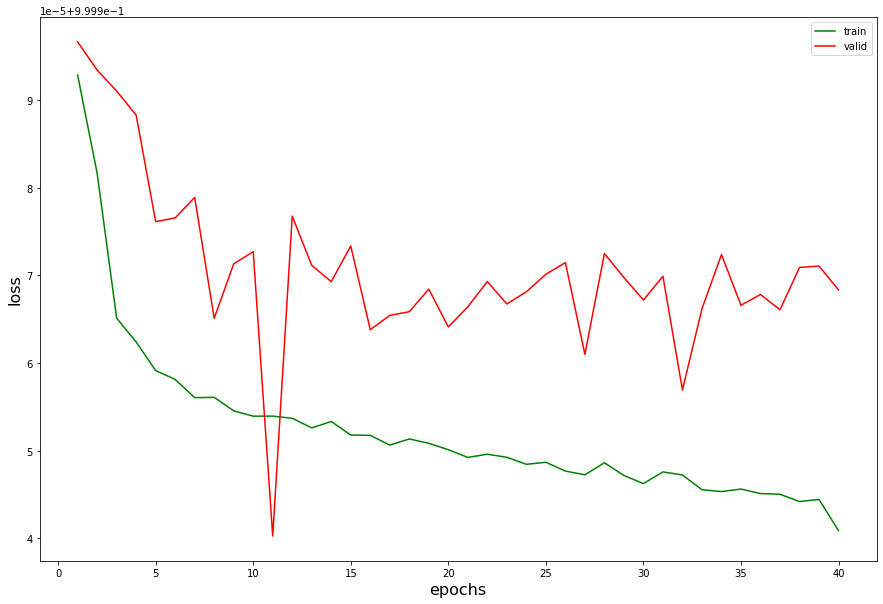

In [42]:
epochs = range(1, len(segnet_dice_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, segnet_dice_tr, label = 'train', color = 'green')
plt.plot(epochs, segnet_dice_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [43]:
def focal_loss(y_real, y_pred, gamma = 2):    
    bce = bce_loss(y_real,y_pred)
    focal_loss = torch.pow((1 - torch.exp(-bce)), gamma) * bce
    return focal_loss

In [44]:
torch.cuda.memory.empty_cache()

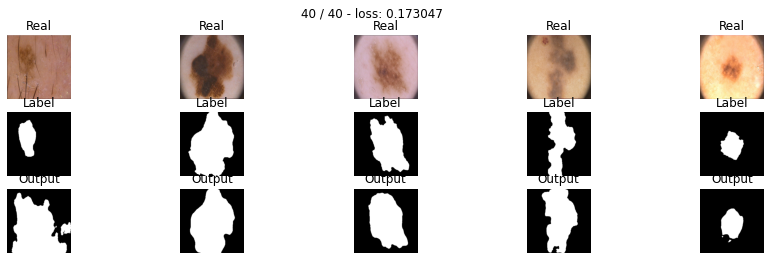

In [45]:
model_focal = SegNet().to(device)

max_epochs = 40
segnet_focal_loss_tr, segnet_focal_loss_val = learn(model_focal, focal_loss, max_epochs, data_tr, data_val)

In [46]:
segnet_focal_loss_val_score = score_model(model_focal, iou_pytorch, data_val)
segnet_focal_loss_val_score

0.7620000123977662

<Figure size 1080x288 with 0 Axes>

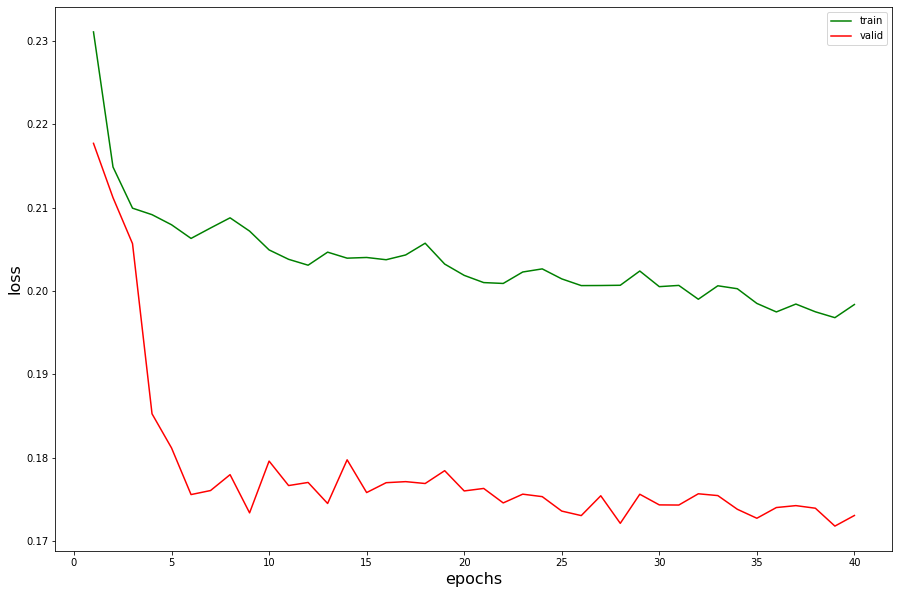

In [47]:
epochs = range(1, len(segnet_focal_loss_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, segnet_focal_loss_tr, label = 'train', color = 'green')
plt.plot(epochs, segnet_focal_loss_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

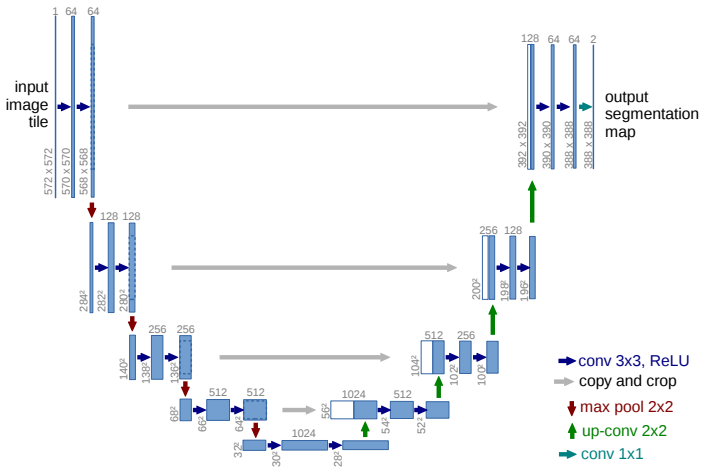

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [48]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 128 -> 64 
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 64 -> 32 
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # bottleneck
        self.bottleneck_pool = nn.MaxPool2d(2, 2)  # 32 -> 16 
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) 
        self.bottleneck_upconv = nn.Upsample(scale_factor=2)  # 16 -> 32
        
        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) 
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc_conv3(p2)
        p3 = self.bottleneck_pool(e3)
        
        # bottleneck
        b = self.bottleneck_upconv(self.bottleneck_conv(p3))
        
        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat([b, e3], dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat([d0, e2], dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat([d1, e1], dim=1)))
        d3 = self.dec_conv3(torch.cat([d2, e0], dim=1))  # no activation
        return d3

Focal loss

In [49]:
torch.cuda.memory.empty_cache()

In [50]:
unet_model_focal = UNet().to(device)

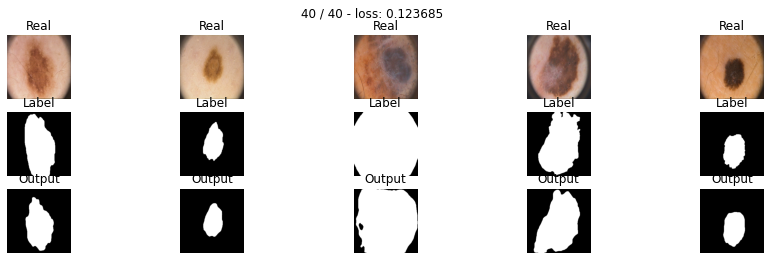

In [51]:
unet_focal_loss_tr, unet_focal_loss_val = learn(unet_model_focal, focal_loss, 40, data_tr, data_val)

In [52]:
unet_focal_val_score = score_model(unet_model_focal, iou_pytorch, data_val)
unet_focal_val_score

0.7660000443458557

<Figure size 1080x288 with 0 Axes>

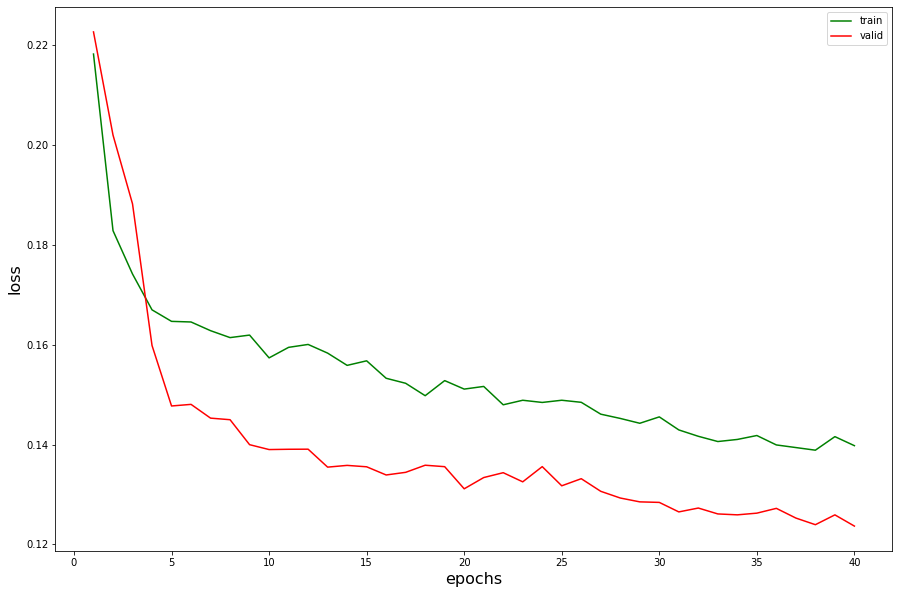

In [53]:
epochs = range(1, len(unet_focal_loss_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, unet_focal_loss_tr, label = 'train', color = 'green')
plt.plot(epochs, unet_focal_loss_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()

BCE loss

In [54]:
torch.cuda.memory.empty_cache()

In [55]:
unet_model_bce = UNet().to(device)

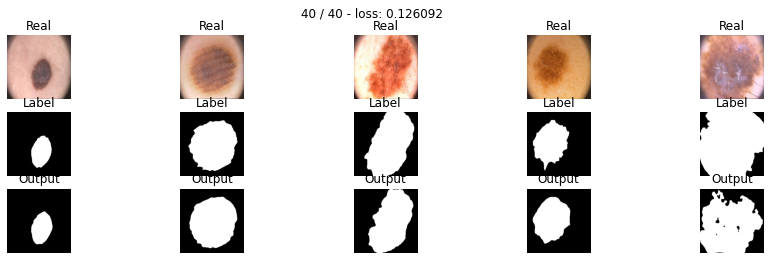

In [56]:
unet_bce_loss_tr, unet_bce_loss_val = learn(unet_model_bce, focal_loss, 40, data_tr, data_val)

In [63]:
unet_bce_val_score = score_model(unet_model_bce, iou_pytorch, data_val)
unet_bce_val_score

0.7620000600814819

<Figure size 1080x288 with 0 Axes>

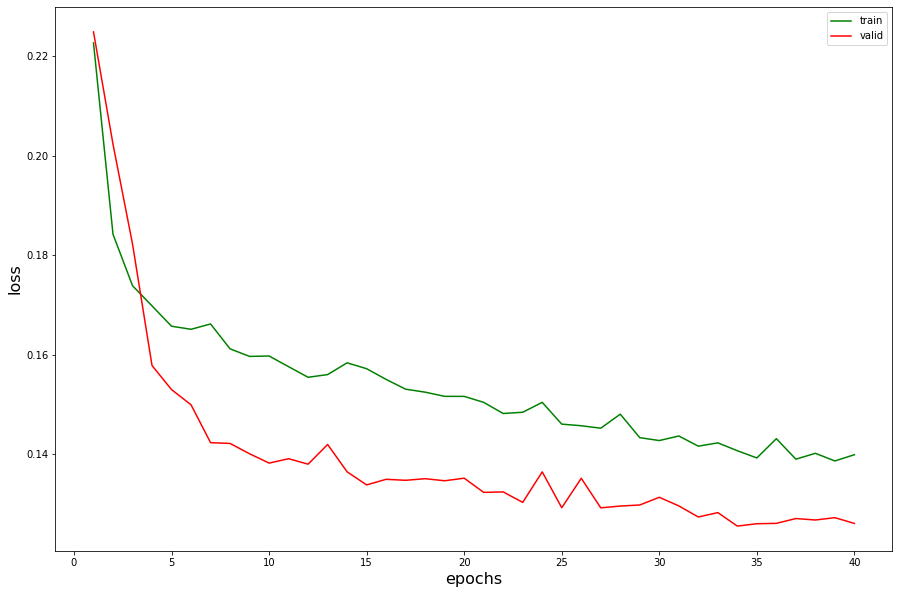

In [58]:
epochs = range(1, len(unet_bce_loss_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, unet_bce_loss_tr, label = 'train', color = 'green')
plt.plot(epochs, unet_bce_loss_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [59]:
class UNet2(UNet):
    def __init__(self):
        super().__init__()

        # encoder poolings
        self.pool0 = nn.Conv2d(64, 64, kernel_size=2, stride=2)  # 256 -> 128
        self.pool1 = nn.Conv2d(128, 128, kernel_size=2, stride=2)  # 128 -> 64  
        self.pool2 = nn.Conv2d(256, 256, kernel_size=2, stride=2)  # 64 -> 32  

        # bottleneck pool and upconv
        self.bottleneck_pool = nn.Conv2d(512, 512, kernel_size=2, stride=2)  # 32 -> 16 
        self.bottleneck_upconv = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)  # 16 -> 32
        
        # decoder (upsampling)
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2) # 32 -> 64
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)  # 64 -> 128
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 128 -> 256

In [60]:
torch.cuda.memory.empty_cache()

In [61]:
unet2_model = UNet2().to(device)

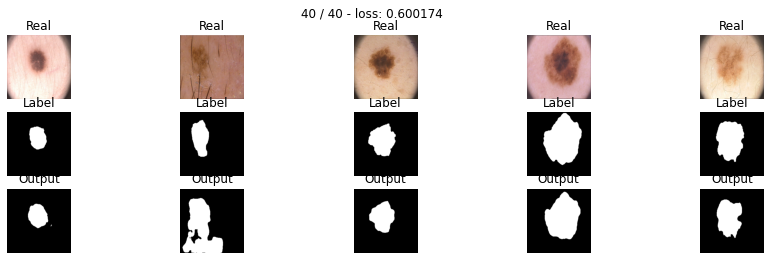

In [62]:
unet2_bce_loss_tr, unet2_bce_loss_val = learn(unet2_model, bce_loss, 40, data_tr, data_val)

In [64]:
unet2_bce_val_score = score_model(unet2_model, iou_pytorch, data_val)
unet2_bce_val_score

0.712000024318695

<Figure size 1080x288 with 0 Axes>

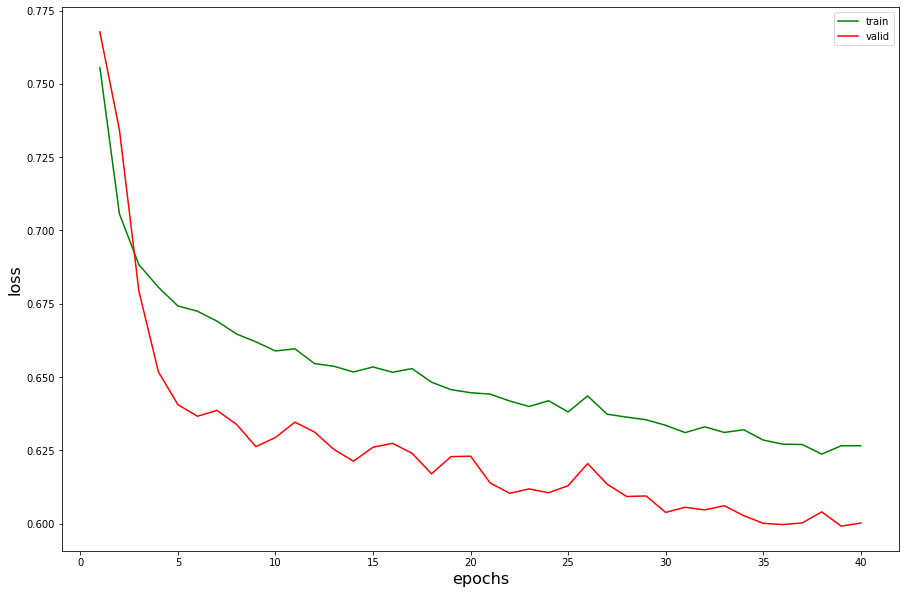

In [65]:
epochs = range(1, len(unet2_bce_loss_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, unet2_bce_loss_tr, label = 'train', color = 'green')
plt.plot(epochs, unet2_bce_loss_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()

In [66]:
torch.cuda.memory.empty_cache()
unet2_model_focal = UNet2().to(device)

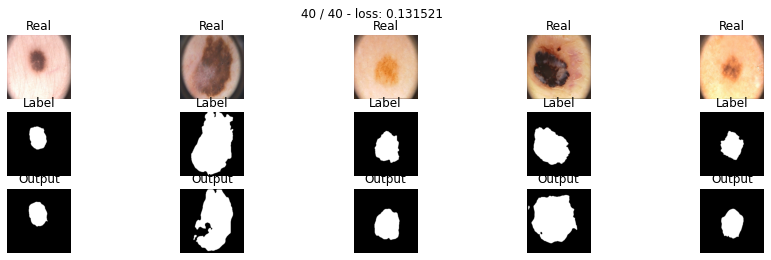

In [68]:
unet2_focal_loss_tr, unet2_focal_loss_val = learn(unet2_model_focal, focal_loss, 40, data_tr, data_val)

In [69]:
unet2_focal_val_score = score_model(unet2_model_focal, iou_pytorch, data_val)
unet2_focal_val_score

0.7360000252723694

<Figure size 1080x288 with 0 Axes>

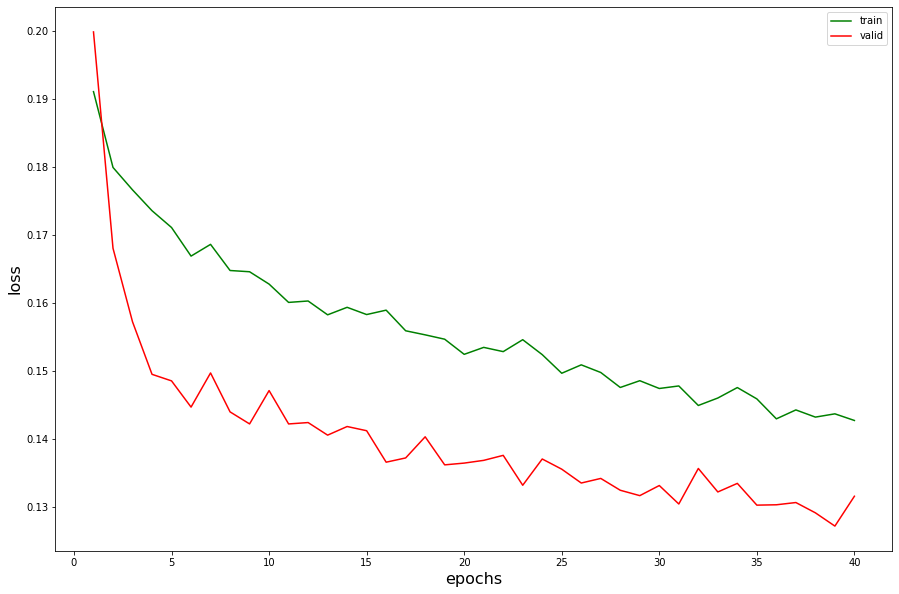

In [70]:
epochs = range(1, len(unet2_focal_loss_tr) + 1)

fig = plt.figure()

plt.figure(figsize = (15, 10))
plt.plot(epochs, unet2_focal_loss_tr, label = 'train', color = 'green')
plt.plot(epochs, unet2_focal_loss_val, label = 'valid', color = 'red')
plt.xlabel('epochs', fontsize = 16)
plt.ylabel('loss', fontsize = 16)
plt.legend()
plt.show()

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 


Общий вывод о проделанной работе:
* Написаны 2 архитектуры сетей - SegNet, Unet, Unet2.
* Написаны 3 функции loss - BCE loss, Dice loss, Focal loss.
* Обучено 7 моделей:
  * SegNet (BCE loss)
  * SegNet (Dice loss)
  * SegNet (Focal loss)
  * Unet (BCE loss)
  * Unet (Focal loss)
  * Unet2 (BCE loss)
  * Unet2 (Focal loss)

Приступим к анализу этих моделей.

1. Для начала сравним размеры обученных моделей, число параметров и скажем, какая из моделей "выигрывает" по этому критерию.

Segnet

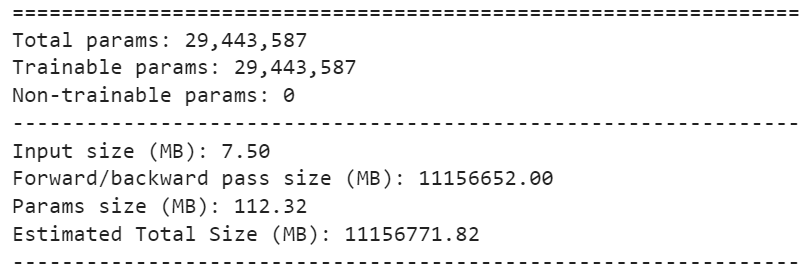

UNet

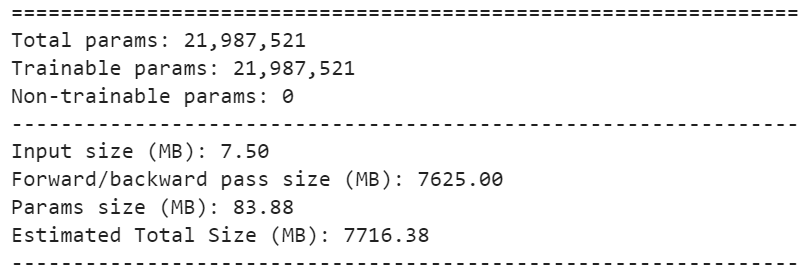

UNet2

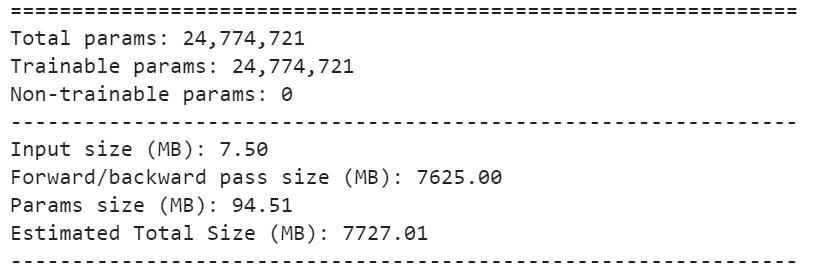

По данным показателям можно сказать, что по количеству параметров и размеру весов "выигрывает" модель UNet (с Max-Pooling и Upsample).

2. На протяжении всего ноутбука после обучения каждой модели были выведены функция потерь для train и valid.

Теперь же отрисуем графики для каждой из модели с разными функциями потерь. Сначала стоит проверить график лоссов на train выборке на каждой из функций. Хоть они и имеют разные по интервалам значения, но по каждому из них в отдельности можно сказать, обучается ли модель.

Segnet

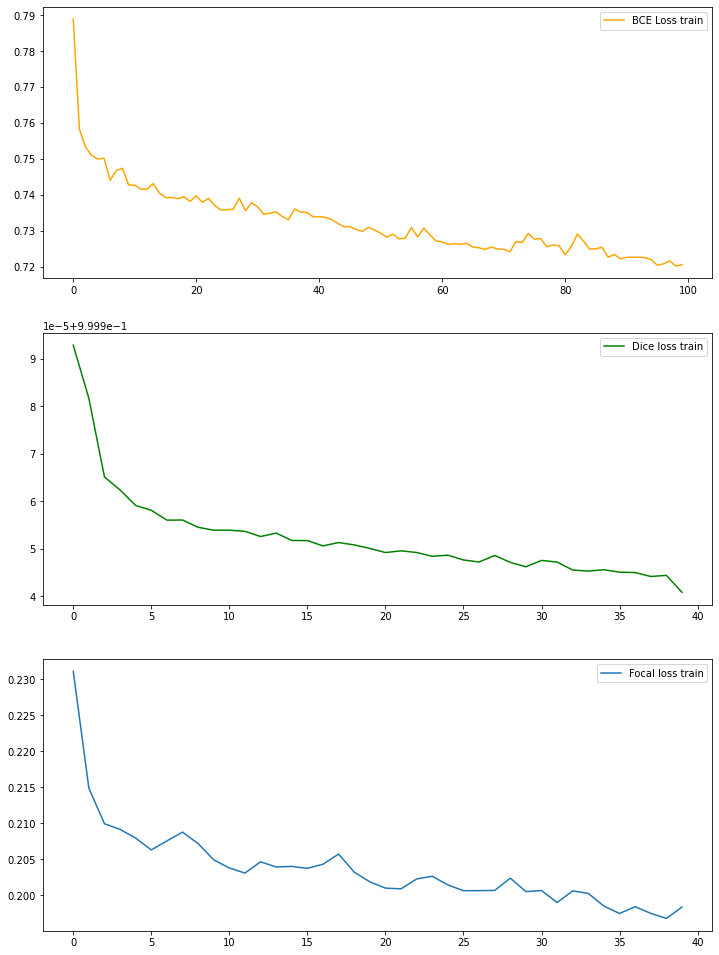

In [89]:
rcParams['figure.figsize'] = (12,17)
plt.subplot(311)
plt.plot(segnet_bce_tr,label='BCE Loss train',color='orange')
plt.legend()
plt.subplot(312)
plt.plot(segnet_dice_tr,label = 'Dice loss train',color='green')
plt.legend()
plt.subplot(313)
plt.plot(segnet_focal_loss_tr, label = 'Focal loss train')
plt.legend()

plt.show()

Как видно из графиков, loss имеет тенденцию к снижению у всех функций, что говорит о том, что модель училась на этих 3 различных функция.
Модель SegNet со всеми лосс функциями ведет себя примерно одинаково.

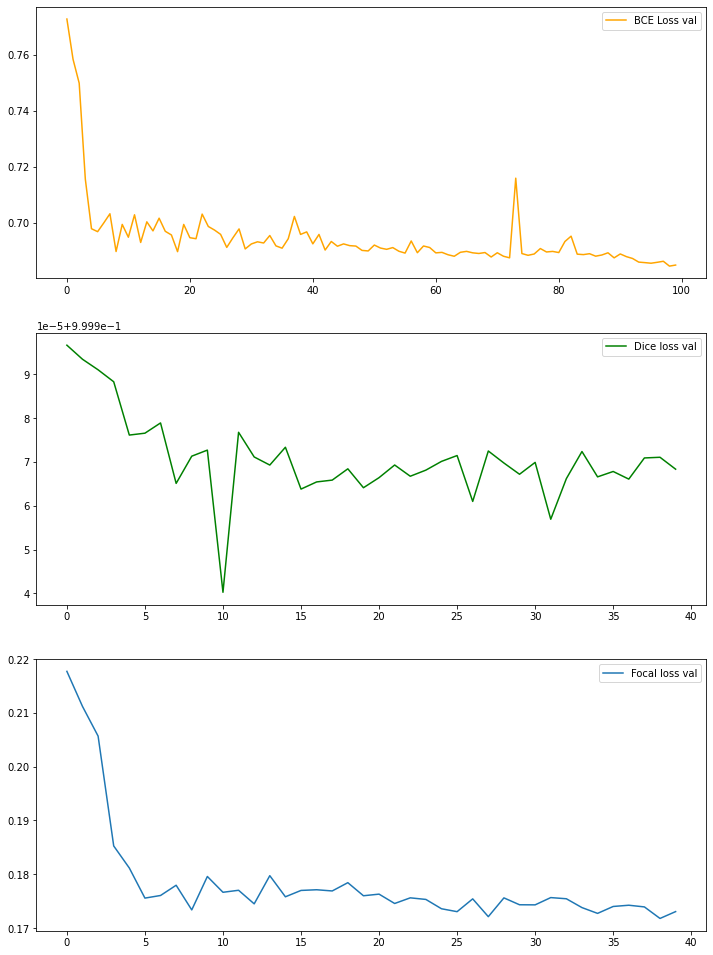

In [90]:
rcParams['figure.figsize'] = (12,17)
plt.subplot(311)
plt.plot(segnet_bce_val,label='BCE Loss val',color='orange')
plt.legend()
plt.subplot(312)
plt.plot(segnet_dice_val,label = 'Dice loss val',color='green')
plt.legend()
plt.subplot(313)
plt.plot(segnet_focal_loss_val, label = 'Focal loss val')
plt.legend()

plt.show()

Однако Dice loss на valid ведет себя очень не стабильно (возможно необходимо  дополнительной численной стабильности).

На valid лосс тоже имеет тенденцию к снижению, следовательно модель не переобучилась (можно обучить модель большее количество эпох).

In [92]:
segnet_bce_val_score, segnet_dice_val_score, segnet_focal_loss_val_score

(0.7480000138282776, 0.7240000128746032, 0.7620000123977662)

In [103]:
score_model(segnet_model_bce, iou_pytorch, data_ts), score_model(model_dice, iou_pytorch, data_ts),  score_model(model_focal, iou_pytorch, data_ts)

(0.8554726839065552, 0.8263944864273072, 0.853656005859375)

Лучшие показатели SegNet были достигнуты на BCE loss

UNet

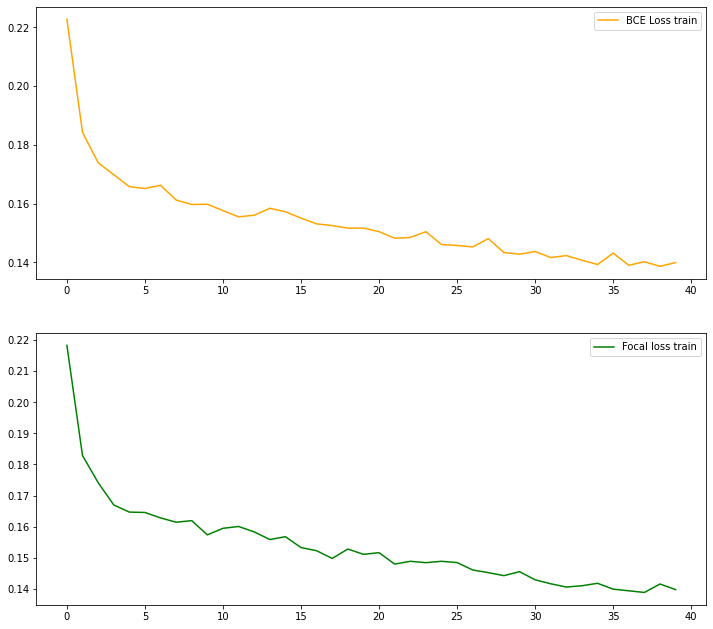

In [97]:
rcParams['figure.figsize'] = (12,17)
plt.subplot(311)
plt.plot(unet_bce_loss_tr,label='BCE Loss train',color='orange')
plt.legend()
plt.subplot(312)
plt.plot(unet_focal_loss_tr,label = 'Focal loss train',color='green')
plt.legend()

plt.show()

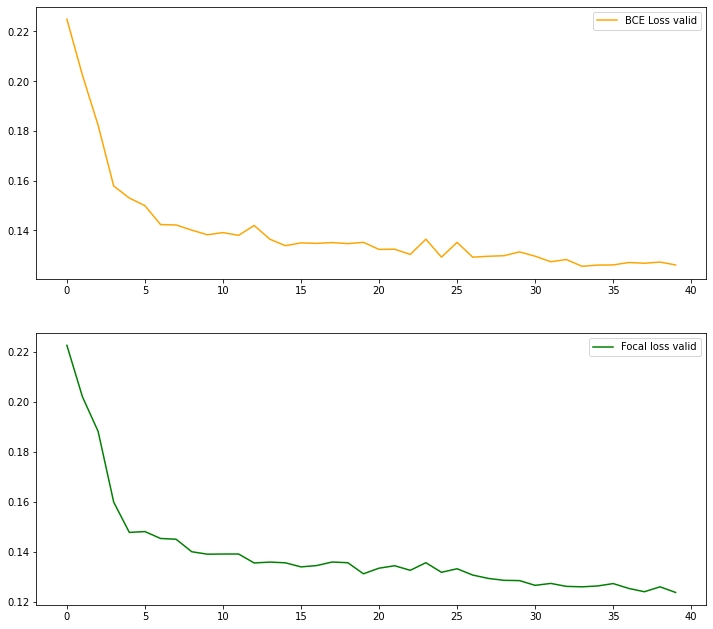

In [98]:
rcParams['figure.figsize'] = (12,17)
plt.subplot(311)
plt.plot(unet_bce_loss_val,label='BCE Loss valid',color='orange')
plt.legend()
plt.subplot(312)
plt.plot(unet_focal_loss_val,label = 'Focal loss valid',color='green')
plt.legend()

plt.show()

In [99]:
unet_bce_val_score, unet_focal_val_score

(0.7620000600814819, 0.7660000443458557)

In [ ]:
score_model(unet_model_bce, iou_pytorch, data_ts), score_model(unet_model_focal, iou_pytorch, data_ts)

Незначительно, но Focal loss дает показатели лучше.

UNet2

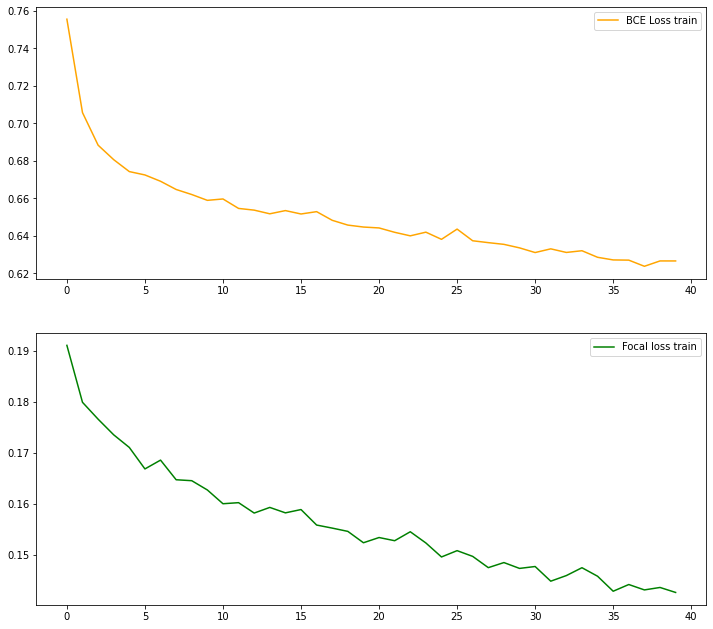

In [100]:
rcParams['figure.figsize'] = (12,17)
plt.subplot(311)
plt.plot(unet2_bce_loss_tr,label='BCE Loss train',color='orange')
plt.legend()
plt.subplot(312)
plt.plot(unet2_focal_loss_tr,label = 'Focal loss train',color='green')
plt.legend()

plt.show()

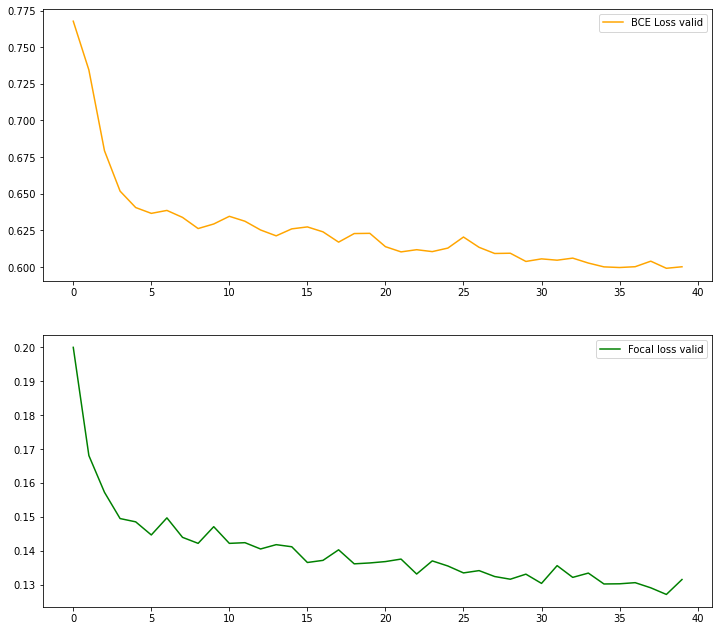

In [101]:
rcParams['figure.figsize'] = (12,17)
plt.subplot(311)
plt.plot(unet2_bce_loss_val,label='BCE Loss valid',color='orange')
plt.legend()
plt.subplot(312)
plt.plot(unet2_focal_loss_val,label = 'Focal loss valid',color='green')
plt.legend()

plt.show()

In [102]:
unet2_bce_val_score, unet2_focal_val_score

(0.712000024318695, 0.7360000252723694)

In [ ]:
score_model(unet2_model_bce, iou_pytorch, data_ts), score_model(unet2_model_focal, iou_pytorch, data_ts)

 Focal loss дает показатели лучше.

Теперь сравним BCE loss SegNet, Focal loss UNet и UNet2.


In [ ]:
score_segnet= [score_model(segnet_model_bce, iou_pytorch, data_ts), score_model(unet_model_focal, iou_pytorch, data_ts), score_model(unet2_model_focal, iou_pytorch, data_ts)]
name_models = ['BCEloss SegNet','Focal loss Unet','Focal loss Unet2']

rcParams['figure.figsize'] = (13,8)
plt.bar(name_models,score_segnet,width=0.5)

**Выводы**

По итогу лучшие показатели оказались у модели UNet с Focal Loss (на нее и были основные ставки :D)

Итоговые показатели далеки от идеала (хотя показатель 85% уже очень обрадовал), работу можно было бы продолжить обучив модель на большем количестве эпох.

Модели UNet и UNet2 не сильно отличаются в рамках проведенного исследования.

SegNet и UNet хорошо показали себя на такой задаче, как сегментация. Лучшей моделью для моих данных оказалась UNet с функцией потерь Focal loss (и при этом она занимает меньше памяти и использует меньше параметров).